# Malmo Project Few-Shot Learning

Guide: https://huggingface.co/blog/setfit

Requires Python 3.7+

`pip install notebook seaborn pandas datasets setfit sentence-transformers torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116`

In [1]:
import pandas as pd
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
import torch

In [2]:
# checking for gpu
torch.cuda.is_available()

True

In [3]:
# reading csv files train and test
label_names = {
    0: "Open chest", 
    1: "Smell plant",
    2: "Go to mob",
    3: "Jump in water", 
    4: "Sit next to campfire",
    5: "Play music",
    6: "Go through fence",
    7: "Go inside door",
    8: "Talk to user",
    9: "Move forward",
    10: "Move backward",
    11: "Strafe left",
    12: "Strafe right",
    13: "Pitch upwards",
    14: "Pitch downwards",
    15: "Turn left",
    16: "Turn right",
    17: "Start jumping",
    18: "Stop movement",
    19: "Start crouching",
    20: "Stop crouching",
    21: "Start attacking",
    22: "Stop attacking",
    23: "Use this",
    24: "Stop using this"
}

dtypes = {"text": str, "label": "int8"}
train_df = pd.read_csv("train.csv", dtype=dtypes)
test_df = pd.read_csv("test.csv", dtype=dtypes)

sample = train_df.sample(5)
sample["task_name"] = sample["label"].map(label_names)
sample

,text,label,task_name
62,"Jerry, put a roof over your head",7,Go inside door
3,"Please, get an item from the storage",0,Open chest
152,Extend your spine,20,Stop crouching
31,Dip your head in the water,3,Jump in water
23,Approach the horse,2,Go to mob


In [4]:
from sklearn.dummy import DummyClassifier
# Baseline, Random
df = pd.read_csv("test.csv")
instances = df["text"].to_list()

train = pd.read_csv("train.csv")
X_train, y_train = train["text"], train["label"]
model = DummyClassifier(strategy="uniform").fit(X_train, y_train)
df["pred"] = model.predict(instances)

print(f"Accuracy: {len(df[df['label']==df['pred']]) / len(df)}")
df

Accuracy: 0.08


,text,label,pred
0,"Hey Jerry, open that container",0,5
1,Get me item from storage,0,23
2,Open that storage and get me something,0,3
3,Get me diamonds from that chest,0,8
4,Go to plant in the world,1,10
...,...,...,...
95,Open this,23,13
96,"Hey Jerry, close this item",24,10
97,Let's close this item,24,5
98,Lets shut this closed,24,15


In [5]:
from sklearn.metrics import f1_score
f1_score(df['label'], df['pred'], average="weighted")

0.06853968253968254

In [6]:
"""
# loading pretrained model as guide
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model
"""

'\n# loading pretrained model as guide\nmodel = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")\nmodel\n'

In [7]:
# loading own dataset instead of the one in the guide
data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset("csv", data_files=data_files)
dataset

Found cached dataset csv (C:/Users/Angel/.cache/huggingface/datasets/csv/default-f10f53e652a53f8c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
})

In [8]:
"""
# building trainer as guide shows
trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    loss_class=CosineSimilarityLoss,
    batch_size=4,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)
"""

'\n# building trainer as guide shows\ntrainer = SetFitTrainer(\n    model=model,\n    train_dataset=dataset["train"],\n    eval_dataset=dataset["test"],\n    loss_class=CosineSimilarityLoss,\n    batch_size=4,\n    num_iterations=20, # Number of text pairs to generate for contrastive learning\n    num_epochs=1 # Number of epochs to use for contrastive learning\n)\n'

In [9]:
"""
# training and getting metrics as shows on guide(just accuracy, I guess)
trainer.train()
metrics = trainer.evaluate()
metrics
"""

'\n# training and getting metrics as shows on guide(just accuracy, I guess)\ntrainer.train()\nmetrics = trainer.evaluate()\nmetrics\n'

In [10]:
model = SetFitModel.from_pretrained("malmoTextClassifier")

In [11]:
# Test/New Instance Results
df = pd.read_csv("test.csv")
instances = df["text"].to_list()
df["pred"] = model(instances)
df["prob"] = torch.max(model.predict_proba(instances), axis=1).values

print(f"Accuracy: {len(df[df['label']==df['pred']]) / len(df)}")
df

Accuracy: 0.96


,text,label,pred,prob
0,"Hey Jerry, open that container",0,0,0.863569
1,Get me item from storage,0,0,0.641588
2,Open that storage and get me something,0,0,0.716273
3,Get me diamonds from that chest,0,0,0.929384
4,Go to plant in the world,1,1,0.935303
...,...,...,...,...
95,Open this,23,23,0.938161
96,"Hey Jerry, close this item",24,24,0.758160
97,Let's close this item,24,24,0.729666
98,Lets shut this closed,24,24,0.439903


In [12]:
df[df.label != df.pred]

,text,label,pred,prob
37,Please move directly to your north,9,12,0.885430
62,Start turning opposite of how clock moves,15,18,0.278570
66,Turn how a clock does,16,10,0.296062
69,Try to touch the sky,17,13,0.755884


In [13]:
f1_score(df.label, df.pred, average="weighted")

0.9593650793650794

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df["label"], df["pred"])

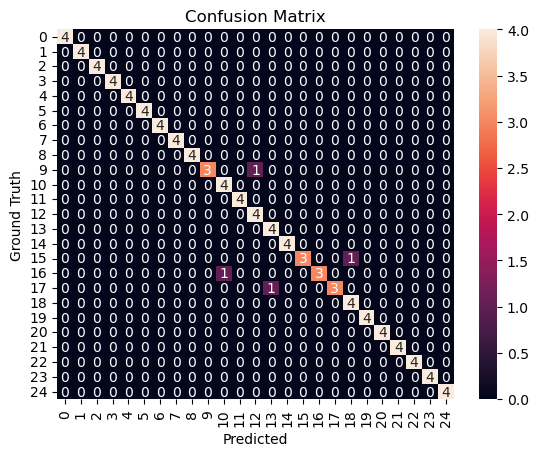

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Just plotting for easier read
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); ax.yaxis.set_ticklabels(label_names);

In [16]:
# Saving model
# trainer.model.save_pretrained("malmoTextClassifier")